In [1]:
#importing basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from sklearn.metrics import *
warnings.filterwarnings('ignore')
%matplotlib inline

#Importing pytorch functions and modules
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms

import librosa
from librosa.core import stft,istft

#Setting random seed for reproducibility
SEED = 1234
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

GeForce GTX 1050


In [2]:
# Fixed variables
epochs = 200               #maximum epochs of training
input_dm1 = 28             #Length of image
input_dm2 = 28             #Breadth of image
output_dm = 10             #Output dimension
early_stopping_rounds = 10  #Epochs after which training should stop if there is no increase in performance

In [3]:
#initializing transformer to convert values to tensor and normalize image matrices
trans = transforms.Compose([
transforms.ToTensor(),
transforms.Normalize((0.1307,), (0.3081,))
])

#Loading datasets
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=trans)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=trans)

#Reading number of samples in each set
n_train = len(mnist_train)
n_test = len(mnist_test)

# # Data loader
# train_loader = torch.utils.data.DataLoader(dataset=mnist_train, 
#                                            batch_size=batch_size, 
#                                            shuffle=True)

# test_loader = torch.utils.data.DataLoader(dataset=mnist_test, 
#                                            batch_size=mnist_test.data.shape[0], 
#                                            shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:09, 1028865.50it/s]                             


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


32768it [00:00, 288765.81it/s]                           
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:02, 589186.96it/s]                              
8192it [00:00, 119742.04it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw
Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [4]:
from helper_file import Linear_Network,train_neural_network,weights_init_uniform_rule

In [5]:

from sklearn.metrics import accuracy_score

#Defining hyper parameters 
batch_size = 7000
dropout = 0.2
learning_rate = 0.001

#Defining model object and applying initialization
my_model = Linear_Network(input_dm1=input_dm1,input_dm2=input_dm2,dropout=dropout).to(device)

Pre-trained model found, to train from scratch set 'saved_model' to None
EPOCH:3
Training to be concluded after this epoch
Average training loss per sample  = tensor(1.4744)
Performance of the network in current epoch = 0.98
Best performance of the network yet  = 0.98
BEST SCORE IS:0.98


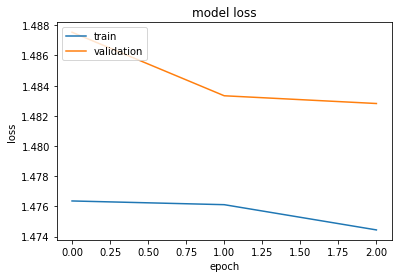

In [6]:
#Carrying out trainingz
result_dict = train_neural_network(model=my_model,
               train_dataset=mnist_train,
               val_dataset=mnist_test,
               epochs=epochs,
               early_stopping_rounds=early_stopping_rounds,
               batch_size=batch_size,
               learning_rate=learning_rate,
               verbose=True,
               eval_func=accuracy_score,
               input_dm1=input_dm1,
               input_dm2=input_dm2,
               criterion=nn.CrossEntropyLoss(),
               saved_model = "saved_model.pt",
               tol=3,
               device=device)

train_loader = result_dict["train_loader"] 
val_images = result_dict["val_images"] 
val_labels = result_dict["val_labels"]
best_model = result_dict["best_model"] 
val_labels_pred = result_dict["val_labels_pred"] 

In [7]:
d_values = [10,20,50,100,200,1024]
val_images_reshaped = val_images.reshape(-1, input_dm1*input_dm2).to(device)

In [8]:
def compress(W,D):
    (U, s, V) = torch.svd(W)
    W_d = torch.mm(torch.mm(U[:,0:D],torch.diag(s)[0:D,0:D]),V[:,0:D].T)
    assert(W.shape==W_d.shape)
    return(W_d)

In [9]:
results = pd.DataFrame()
for D in d_values:
    new_model = Linear_Network(input_dm1=input_dm1,input_dm2=input_dm2,dropout=dropout).to(device)
    
    #Making sure that apart from the weights we are modifying, all other parameters have the same value
    new_model.load_state_dict(my_model.state_dict())
    
    w = new_model.input_layer.weight.data
    new_model.input_layer.weight.data = compress(w,min(w.shape[0],w.shape[0],D))
    new_model.hidden_layer_1.weight.data = compress(new_model.hidden_layer_1.weight.data,D)
    new_model.hidden_layer_2.weight.data = compress(new_model.hidden_layer_2.weight.data,D)
    new_model.hidden_layer_3.weight.data = compress(new_model.hidden_layer_3.weight.data,D)
    new_model.hidden_layer_4.weight.data = compress(new_model.hidden_layer_4.weight.data,D)
    new_model.hidden_layer_5.weight.data = compress(new_model.hidden_layer_5.weight.data,D)
    
    
    val_labels_pred = new_model.forward(val_images_reshaped).argmax(1).cpu().numpy()
    test_accuracy = accuracy_score(val_labels.numpy(),val_labels_pred)
    results = results.append({"D":D,"test_accuracy":round(test_accuracy,3)},ignore_index=True)
results

,D,test_accuracy
0,10.0,0.795
1,20.0,0.960
2,50.0,0.978
3,100.0,0.978
4,200.0,0.978
5,1024.0,0.978


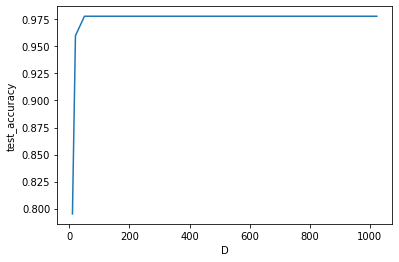

In [10]:
plt.figure()
sns.lineplot(x="D",y="test_accuracy",data=results)

if x1 and x2 represent activations of two consecutive linear layers in a NN,
x2 = f(W * x1 + b) where W,b and f are the weight, bias and activation function respectively
If we are to replace W with a lower dimensional U and V respectively where weights of both are learned simultaneously, we will essential replace one layer with two layers  so that xm is the intermediary activation. 

Now, we have
x2 = f2(V * x_m + b2)
x_m = f1(U * x1 + b1)

The only modification is that f1 is identity function and b1 will be 0 and constant

In [22]:
def compress_U(W,D):
    (U, s, V) = torch.svd(W)
    U_D = U[:,0:D]
    U_D.required_grad = True
    return(U_D)

def compress_V_T(W,D):
    (U, s, V) = torch.svd(W)
    V_D = V[:,0:D].T
    V_D.required_grad = True
    return(V_D)

In [31]:
class Custom_Linear_Network(nn.Module):
    def __init__(self,input_dm1,input_dm2,D,original_model,dropout=0):
        super(Custom_Linear_Network,self).__init__()
        
        #instead of self.input_layer = nn.Linear(784,1024)
        self.v_inp = nn.Linear(input_dm1*input_dm2, D,bias=False)
        self.u_inp = nn.Linear(D,1024)
        #initializing U and V based on SVD
        self.v_inp.weight.data = compress_V_T(original_model.input_layer.weight.data,D)
        self.u_inp.weight.data = compress_U(original_model.input_layer.weight.data,D)
        
        
        
        
        
        self.v1 = nn.Linear(1024,D,bias=False)  
        self.u1 = nn.Linear(D, 1024)
        #initializing U and V based on SVD
        self.v1.weight.data = compress_V_T(original_model.hidden_layer_1.weight.data,D)
        self.u1.weight.data = compress_U(original_model.hidden_layer_1.weight.data,D)
        
        
        self.v2 = nn.Linear(1024,D,bias=False)  
        self.u2 = nn.Linear(D, 1024)
        #initializing U and V based on SVD
        self.v2.weight.data = compress_V_T(original_model.hidden_layer_2.weight.data,D)
        self.u2.weight.data = compress_U(original_model.hidden_layer_2.weight.data,D)
        
        self.v3 = nn.Linear(1024,D,bias=False)  
        self.u3 = nn.Linear(D, 1024)
        #initializing U and V based on SVD
        self.v3.weight.data = compress_V_T(original_model.hidden_layer_3.weight.data,D)
        self.u3.weight.data = compress_U(original_model.hidden_layer_3.weight.data,D)
        
        
        self.v4 = nn.Linear(1024,D,bias=False)  
        self.u4 = nn.Linear(D, 1024)
        #initializing U and V based on SVD
        self.v4.weight.data = compress_V_T(original_model.hidden_layer_4.weight.data,D)
        self.u4.weight.data = compress_U(original_model.hidden_layer_4.weight.data,D)
        
        self.v5 = nn.Linear(1024,D,bias=False)  
        self.u5 = nn.Linear(D, 1024)
        #initializing U and V based on SVD
        self.v5.weight.data = compress_V_T(original_model.hidden_layer_5.weight.data,D)
        self.u5.weight.data = compress_U(original_model.hidden_layer_5.weight.data,D)
        
        self.output_layer = nn.Linear(1024, 10)
        self.dd = nn.Dropout(dropout)

        
    def forward(self, x):
        
        x = self.v_inp(x)
        x = self.u_inp(x)
        x = F.relu(x)
        x = self.dd(x)
        
        #5 hidden layers
        x = self.v1(x)
        x = self.u1(x)
        x = F.relu(x)
        x = self.dd(x)
        x = self.v2(x)
        x = self.u2(x)
        x = F.relu(x)
        x = self.dd(x)
        x = self.v3(x)
        x = self.u3(x)
        x = F.relu(x)
        x = self.dd(x)
        x = self.v4(x)
        x = self.u4(x)
        x = F.relu(x)
        x = self.dd(x)
        x = self.v5(x)
        x = self.u5(x)
        x = F.relu(x)
        x = self.dd(x)
        
        
        
     
        x = self.output_layer(x)
        x = F.softmax(x, dim=1)
        
        return x

In [32]:
compressed_model = Custom_Linear_Network(input_dm1 = 28,
                           input_dm2 = 28,
                           D = 20,
                           original_model = my_model,
                           dropout = 0.2).to(device)


EPOCH:5
Average training loss per sample  = tensor(1.8647)
Performance of the network in current epoch = 0.65
Best performance of the network yet  = 0.65
EPOCH:10
Average training loss per sample  = tensor(1.6764)
Performance of the network in current epoch = 0.78
Best performance of the network yet  = 0.78
EPOCH:15
Average training loss per sample  = tensor(1.6447)
Performance of the network in current epoch = 0.85
Best performance of the network yet  = 0.85
EPOCH:20
Average training loss per sample  = tensor(1.4947)
Performance of the network in current epoch = 0.96
Best performance of the network yet  = 0.96
EPOCH:25
Average training loss per sample  = tensor(1.4888)
Performance of the network in current epoch = 0.96
Best performance of the network yet  = 0.97
EPOCH:30
Average training loss per sample  = tensor(1.4846)
Performance of the network in current epoch = 0.97
Best performance of the network yet  = 0.97
EPOCH:35
Average training loss per sample  = tensor(1.4810)
Performance

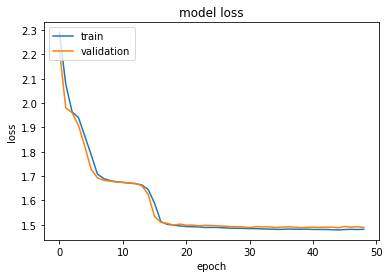

In [33]:
result_dict_compressed = train_neural_network(model=compressed_model,
               train_dataset=mnist_train,
               val_dataset=mnist_test,
               epochs=epochs,
               early_stopping_rounds=early_stopping_rounds,
               batch_size=batch_size,
               learning_rate=learning_rate,
               verbose=True,
               eval_func=accuracy_score,
               input_dm1=input_dm1,
               input_dm2=input_dm2,
               criterion=nn.CrossEntropyLoss(),
               tol=3,
               saved_model=None,
               device=device)

In [34]:
#Comparison of forward pass time of both the networks
import time
t1 = time.time()
p1 = my_model.forward(val_images_reshaped)
t2 = time.time()
print("For original network, forward pass time per sample = "+str((t2-t1)/val_images_reshaped.shape[0]))
t3 = time.time()
p1 = compressed_model.forward(val_images_reshaped)
t4 = time.time()
print("For compressed network, forward pass time per sample = "+str((t4-t3)/val_images_reshaped.shape[0]))

For original network, forward pass time per sample = 3.590583801269531e-07
For compressed network, forward pass time per sample = 2.902984619140625e-07


In [3]:
train_dataset = np.arange(0,1200)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                             batch_size=100, 
                                             shuffle=True)

In [5]:
for batch in train_loader:
    print(batch.shape)

torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])


In [6]:
batch

tensor([ 201,   52,  144,  337, 1152,   31,  526, 1153,  834,  244,  633,  165,
         898, 1145, 1175,  979,  331,  450,  668, 1174,  113,  957,   43,  961,
         324,  249,  530,  682, 1034,  339,  441,  944,  378,  470,  722,  139,
        1099,  952, 1162,  559, 1143,  601,  548,  589,  438,  308,  616,  740,
         254,  359,  918, 1194,  896,    4,  215,  718,  876,  360, 1131,  746,
         873,  326, 1112,  647,  299,  465,  764, 1005,   81,  561, 1196,  704,
         800,  680,    3,  380,  995,  936, 1072,  778,  627,  603,  128,  502,
         187,  368,  546,   22, 1134,  990,  118,  615,    0, 1182,  631,  735,
        1119,  628,  969,  847])

# Problem 2

In [ ]:
n_batch = 1200
max_len = 180
input_dm = 513

nos = np.arange(0,n_signals).astype(np.str)
l_max = 0
if(("S_complex.npy" in os.listdir())&("seq_lengths.npy" in os.listdir())):
    S_complex = np.load("S_complex.npy")
    seq_lengths = np.load("seq_lengths.npy").astype(np.int)
else:
    S_complex = np.zeros((n_signals,input_dm,max_len)).astype(np.complex64)
    seq_lengths = np.zeros((n_signals)).astype(np.int)
    for i,no in enumerate(nos):
        filename = "tr/trs" + no.zfill(4) + ".wav"
        s, sr=librosa.load(filename, sr=None)
        s_complex = stft(s, n_fft=1024, hop_length=512)
        seq_lengths[i] = int(s_complex.shape[1])
        S_complex[i,:,0:seq_lengths[i]] = s_complex
    

    len_sort_ind = np.flip(np.argsort(seq_lengths))
    
    #sort S by decreasing order of length
    S_complex = S_complex[len_sort_ind]
    seq_lengths = seq_lengths[len_sort_ind]
    np.save("S_complex.npy",S_complex)
    np.save("seq_lengths.npy",S_complex)

S = np.abs(S_complex)
S_cap = np.nan_to_num(np.divide(S_complex,S))

print(seq_lengths.shape)

In [ ]:
if("X_complex.npy" in os.listdir()):
    X_complex = np.load("X_complex.npy")
else:
    X_complex = np.zeros((n_signals,input_dm,max_len)).astype(np.complex64)
    for i,no in enumerate(nos):
        filename = "tr/trs" + no.zfill(4) + ".wav"
        x, sr=librosa.load(filename, sr=None)
        x_complex = stft(x, n_fft=1024, hop_length=512)
        l = x_complex.shape[1]
        X_complex[i,:,0:l] = x_complex
    
    X_complex = X_complex[len_sort_ind]
    np.save("X_complex.npy",X_complex)

X = np.abs(X_complex)
X_cap = np.nan_to_num(np.divide(X_complex,X))

In [ ]:
if("N_complex.npy" in os.listdir()):
    N_complex = np.load("N_complex.npy")
else:
    N_complex = np.zeros((n_signals,input_dm,max_len)).astype(np.complex64)
    for i,no in enumerate(nos):
        filename = "tr/trn" + no.zfill(4) + ".wav"
        n, sr=librosa.load(filename, sr=None)
        n_complex = stft(n, n_fft=1024, hop_length=512)
        l = n_complex.shape[1]
        N_complex[i,:,0:l] = n_complex
    
    N_complex = N_complex[len_sort_ind]    
    np.save("N_complex.npy",N_complex)

N = np.abs(N_complex)

In [139]:



M = np.greater(S,N).astype(np.float64)
seq_lengths = torch.tensor(seq_lengths).to(device)
X = torch.tensor(X.reshape((n_signals,max_len,input_dm))).to(device)
S = torch.tensor(S.reshape((n_signals,max_len,input_dm))).to(device)
N = torch.tensor(N.reshape((n_signals,max_len,input_dm))).to(device)
M = torch.tensor(M.reshape((n_signals,max_len,input_dm))).to(device)

In [59]:
X_packed = nn.utils.rnn.pack_padded_sequence(X,seq_lengths, batch_first=True)

In [60]:
lstm = nn.LSTM(
            input_size=input_dm,
            hidden_size=513,
            num_layers=1,
            batch_first=True,
            dropout = 0.2,
            bidirectional=True
        ).to(device)

In [61]:
X_packed, (hidden, cell) = lstm(X_packed)
X_out,_ = nn.utils.rnn.pad_packed_sequence(X_packed, batch_first=True, padding_value=0.0, total_length=None)
X_out.shape

torch.Size([100, 139, 1026])

In [62]:
X_out = X_out.reshape(X_out.shape[0],X_out.shape[1],2,513)

In [63]:
X_out = X_out[:,:,0,:]

In [64]:
F.sigmoid(X_out).shape

torch.Size([100, 139, 513])

In [94]:
class denoise_RNN(nn.Module):
    def __init__(self, input_dm, n_lstm_layers, n_lstm_units, output_dm,dropout,max_len):
        
        super(denoise_RNN,self).__init__()
        
        self.n_lstm_units = n_lstm_units
        self.output_dm = output_dm
        self.max_len = max_len

        # design LSTM
        self.lstm = nn.LSTM(
            input_size=input_dm,
            hidden_size=n_lstm_units,
            num_layers=n_lstm_layers,
            batch_first=True,
            dropout = dropout,
            bidirectional=True
        )
        
        # output layer which projects back to tag space
        self.hidden_to_linear = nn.Linear(n_lstm_units,output_dm)


    def forward(self, X, X_lengths):
        
        X_packed = nn.utils.rnn.pack_padded_sequence(X,X_lengths, batch_first=True)
        X_packed, (hidden, cell) = self.lstm(X_packed)
        X_out,_ = nn.utils.rnn.pad_packed_sequence(X_packed, batch_first=True, 
                                                   padding_value=0.0, total_length=self.max_len)
        
        print(X_out.shape)
        X_out = X_out.reshape(X_out.shape[0],self.max_len,2,self.n_lstm_units)
        M_hat = F.sigmoid(X_out[:,:,0,:])
               
        return M_hat
    
    def pad_ignore_flatten(M_hat,X_lengths):
        


In [95]:
rnn_model = denoise_RNN(input_dm=input_dm, 
                        n_lstm_layers=1,
                        n_lstm_units=513,
                        output_dm=513,
                        dropout=0.2,
                        max_len=max_len).to(device)

In [101]:
M_hat.shape

torch.Size([100, 180, 513])

In [99]:
M_hat.squeeze().shape

torch.Size([100, 180, 513])

In [151]:
M_hat_in = 1 - M_hat

In [152]:
M_hat_in.shape

torch.Size([100, 180, 513])

In [165]:
criterion = nn.BCELoss(reduction="sum")

In [166]:
y_hat = torch.tensor([[0.5,0.25,0.25]])
y = torch.tensor([[1,0,1]]).float()
criterion(y_hat,y)

tensor(2.3671)

In [168]:
batch_ce_loss = 0.0
for i in range(M_hat.size(0)):
    ce_loss = criterion(M_hat[i,0:seq_lengths[i],:].view(1,-1), M[i,0:seq_lengths[i],:].view(1,-1).float())
    batch_ce_loss += ce_loss
batch_ce_loss.backward()

In [163]:
M[i,0:seq_lengths[i],:].view(1,-1).float()

tensor([[0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [164]:
criterion(M_hat[i,0:seq_lengths[i],:].view(1,-1),M[i,0:seq_lengths[i],:].view(1,-1).float())

tensor(0.6934, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

In [131]:
type(seq_lengths[0])

torch.Tensor

In [132]:
seq_lengths[0]

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0')

In [130]:
M_hat[0,0:seq_lengths[0],:].shape

TypeError: only integer tensors of a single element can be converted to an index

In [109]:
M_hat[i,0:seq_lengths[0],:].view(1,-1).shape

torch.Size([1, 71307])

In [169]:
100/30

3.3333333333333335

In [173]:
np.ceil(100/30)

4.0

In [174]:
def make_batches(X,M,seq_lengths,batch_size):
    batch = []
    n = X.shape[0]
    b = int(np.ceil(n/batch_size))
    for i in range(0,b):
        s = i*batch_size
        e = min((i+1)*(batch_size),n)
        sl_batch = seq_length[s:e]
        seq = np.argsort(sl_batch)
        sl_batch = sl_batch
        x_batch = X[s:e]
        m_batch = M[s:e]
        
        
        batch.append((,M[s:e],seq_length))

0
30
30
60
60
90
90
100
